In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline


In [26]:
import pandas as pd
import numpy as np
from pandas import Series, DataFrame
from datetime import datetime
import matplotlib.pyplot as plt

import cvxpy as cv

"""
    Calculate max return optimization with max risk tolerated used as a constraint
    returns tickers distribution in the portfolio and return rate in np.array
"""

def MarkowitzOpt(mean, variance, covariance, interest_rate, min_return, max_risk):
    print(f"mean {mean}")
    print(f"variance {variance})
    # Maximize return part
    n = mean.size                   # Number of assets (number of stocks + interest rate)
    mu = mean.values                    # Mean returns of n assets
    #print(mu)
    Sigma = np.zeros((n,n))                 # Covariance of n assets
    counter = 0
    for i in np.arange(n):
        for j in np.arange(i, n):
            if i==j:
                Sigma[i,j] = variance[i]
            else:
                Sigma[i,j] = covariance[counter]
                Sigma[j,i] = Sigma[i,j]
                counter += 1
                
    w = cv.Variable(n)                         # Portfolio allocation vector
    ret = mu.T*w
    risk = cv.quad_form(w, Sigma)
    max_risk_param = cv.Parameter()
    max_risk_param.value = max_risk
    prob = cv.Problem(cv.Maximize(ret),          # Restricting to long-only portfolio
                   [cv.sqrt(cv.sum(risk)) <= max_risk,
                    cv.sum(w) == 1,
                   w >= 0])
    prob.solve(qcp=True)
    # No solution check
    if prob.status in ["infeasible", "unbounded"]:
        return np.zeros((n+1,1))
    
    risk = np.dot(np.power(w.value, 2), variance.ravel().reshape((len(mu),1)))
    portfolio_and_rate = np.append(w.value, sum(w.value.T*mu))
    print(f'max return risk: {(risk**0.5)[0]} return: {np.sum(w.value.T*mean)}')
    #print(w.value)
    
    # Minimize risk part     
    # Ensuring feasability of inequality constraint
    if mu.max() < min_return:
        min_return = interest_rate
    
    w = cv.Variable(n)                         # Portfolio allocation vector
    ret = mu.T*w
    risk = cv.quad_form(w, Sigma)
    min_ret = cv.Parameter()
    min_ret.value = min_return
    prob = cv.Problem(cv.Minimize(risk),          # Restricting to long-only portfolio
                   [ret >= min_ret,
                   cv.sum(w) == 1,
                   w >= 0])
    prob.solve()

    # Add min risk optimization returns  
    if prob.status not in ["infeasible", "unbounded"]:
        risk = np.dot(np.power(w.value, 2), variance.ravel().reshape((len(mu),1)))
        print(f"min risk risk: {risk**0.5} return: {np.sum(w.value.T*mean)}")
        portfolio_and_rate = np.append(portfolio_and_rate, sum(w.value.T*mean))
    else: 
        print("not feasible")
        portfolio_and_rate = np.append(portfolio_and_rate, 0.0)
    
    return portfolio_and_rate



StockList = ['SBER','ALRS','GMKN','PLZL','RTKM','SNGS'] # Stock ticker names
max_risk = 0.1
interest_rate = 0.03/12# Fixed interest rate
min_return = 0.02# Minimum desired return


# Read stock prices data
#price = pd.read_csv('StockPrices.csv')
price = pd.read_csv('refined.txt',sep='\t')
price.index = [datetime.strptime(x,'%Y-%m-%d') for x in price['Date']]
price = price.drop('Date',1)

# Specify number of days to shift
shift = 60
# Compute returns over the time period specified by shift
shift_returns = price/price.shift(shift) - 1

# Specify filter "length"
filter_len = shift
# Compute mean and variance
shift_returns_mean = shift_returns.ewm(span=filter_len).mean()
shift_returns_var = shift_returns.ewm(span=filter_len).var()
# Compute covariances
NumStocks = len(StockList)
covariance = pd.DataFrame()
for FirstStock in np.arange(NumStocks-1):
    for SecondStock in np.arange(FirstStock+1,NumStocks):
        ColumnTitle = StockList[FirstStock] + '-' + StockList[SecondStock]
        covariance[ColumnTitle] = shift_returns[StockList[FirstStock]].ewm(span=filter_len).cov(shift_returns[StockList[SecondStock]])


# Variable Initialization
start_date = '2017-02-20'
index = shift_returns.index
start_index = index.get_loc(start_date)
end_date = index[-1]
end_index = index.get_loc(end_date)
date_index_iter = start_index
StockList.append('InterestRate')
distribution = DataFrame(index=StockList)
returns = Series(index=index)
real_returns = Series(index=index)
min_returns = Series(index=index)
# Start Value
max_total_value = 1.0
real_total_value = 1.0
min_total_value = 1.0
returns[index[date_index_iter]] = max_total_value
real_returns[index[date_index_iter]] = real_total_value
min_returns[index[date_index_iter]] = min_total_value


while date_index_iter + shift < end_index:
    date = index[date_index_iter]
    if date_index_iter > start_index:
        real_total_value += np.sum(shift_returns_mean.loc[date].T * portfolio_alloc[:-2])
    #print(real_total_value)
    portfolio_alloc = MarkowitzOpt(shift_returns_mean.loc[date], shift_returns_var.loc[date], covariance.loc[date], interest_rate, min_return, max_risk)
    distribution[date.strftime('%Y-%m-%d')] = portfolio_alloc[:-1] # put all but min risk returns estimate

    # Calculating portfolio return
    max_total_value = max_total_value + portfolio_alloc[-2] # max + max returns estimate
    min_total_value = min_total_value + portfolio_alloc[-1]
    # Increment Date
    date_index_iter += shift
    returns[index[date_index_iter]] = max_total_value
    real_returns[index[date_index_iter]] = real_total_value
    min_returns[index[date_index_iter]] = min_total_value

# Remove dates that there are no trades from returns
returns = returns[np.isfinite(returns)]
real_returns = real_returns[np.isfinite(real_returns)]
min_returns = min_returns[np.isfinite(min_returns)]

DQCPError: The problem is not DQCP.

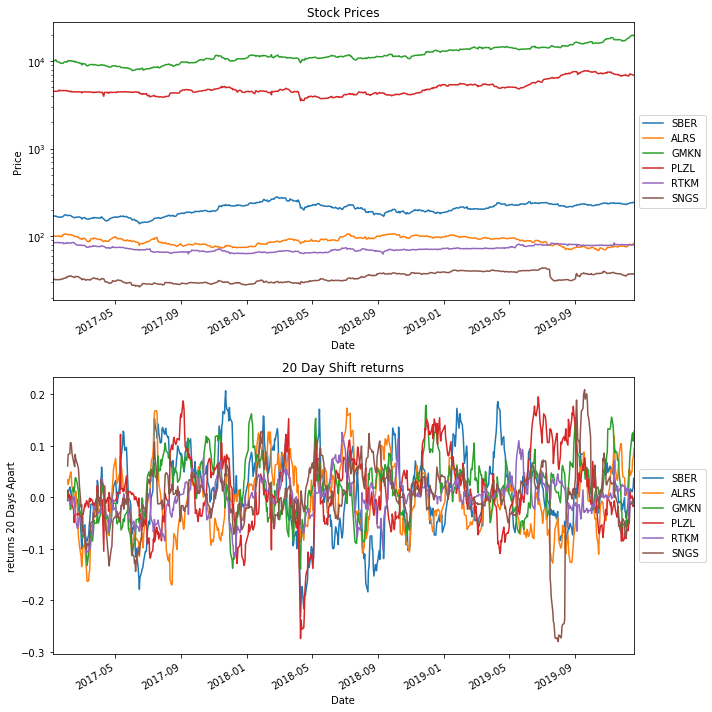

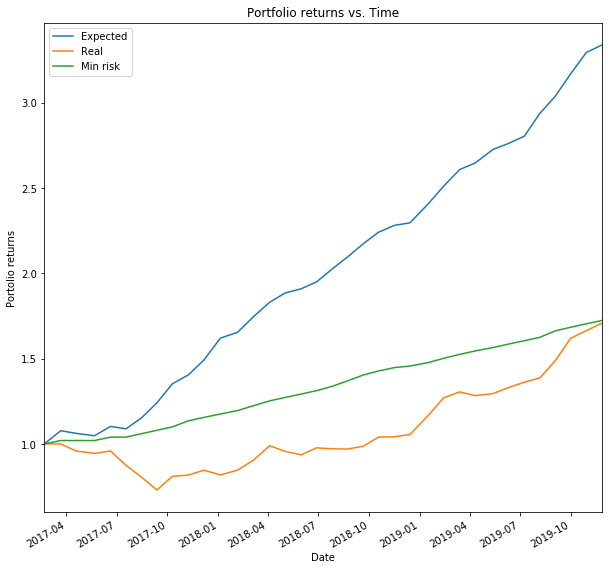

In [21]:
plt.rcParams["figure.figsize"] = (10,10)

# Plot stock prices and shifted returns
fig, axes = plt.subplots(nrows=2,ncols=1)
axes[0].set_yscale('log')
price.plot(ax=axes[0])
shift_returns.plot(ax=axes[1])
axes[0].set_title('Stock Prices')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Price')
axes[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))

axes[1].set_title(str(shift)+ ' Day Shift returns')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('returns ' + str(shift) + ' Days Apart')
axes[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.tight_layout()
# Plot portfolio returns vs. time
plt.figure()
returns.plot()
real_returns.plot()
min_returns.plot()
plt.xlabel('Date')
plt.ylabel('Portolio returns')
plt.title('Portfolio returns vs. Time')
plt.legend(['Expected', 'Real','Min risk'])

plt.show()


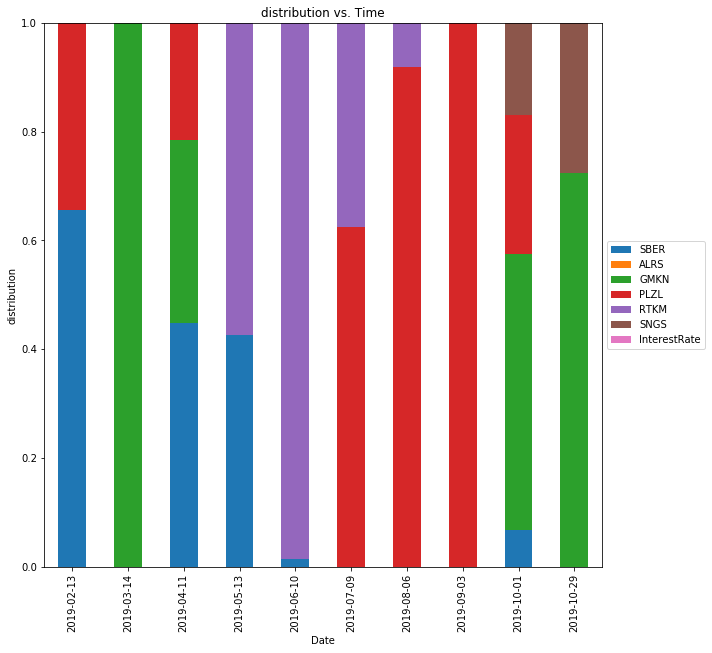

In [4]:
# Plot portfolio allocation of last 10 periods
ax = distribution.T.iloc[-10:].plot(kind='bar',stacked=True)
plt.ylim([0,1])
plt.xlabel('Date')
plt.ylabel('distribution')
plt.title('distribution vs. Time')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()